In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
test = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)
batch_size=256

In [4]:
from cnn import CNN

In [6]:
trainloader = torch.utils.data.DataLoader(dataset=fashion, batch_size=128, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=128, shuffle=False)

In [8]:
def load_subset(idx):
    f_path = f'subsets/split_{idx}'
    with open(f_path, 'rb') as f:
        subset = np.load(f)
    return subset

In [9]:
def load_model(idx):
    f_path = f'models/split_{idx}'
    model = CNN(10)
    model.load_state_dict(torch.load(f_path, weights_only=True))
    model.to(device)
    return model

In [10]:
def get_correctness_for_model(model):
    model.eval()
    trainset_correctness = []
    with torch.no_grad():
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            correctness = (predicted == targets).float()
            trainset_correctness.append(correctness)
    
    trainset_correctness = torch.cat(trainset_correctness).cpu()
    return trainset_correctness

In [12]:
def get_correctness():
    results = []
    for idx in range(2000):
        if (idx+1) % 100 == 0:
            print(f'Loading results for idx {idx+1}...')
        subset_idx = load_subset(idx)
        mask = np.zeros(len(fashion), dtype=bool)
        mask[subset_idx] = True
        model = load_model(idx)
        correctness = get_correctness_for_model(model)
        results.append((mask, correctness))
    
    mask_matrix = np.vstack([ret[0] for ret in results])
    correctness_matrix = np.vstack([ret[1] for ret in results])

    return mask_matrix, correctness_matrix

In [13]:
trainset_mask, trainset_correctness = get_correctness()
with open('correctness.npy', 'wb') as f:
    np.save(f, trainset_correctness)
with open('trainset_mask.npy', 'wb') as f:
    np.save(f, trainset_mask)

Loading results for idx 100...
Loading results for idx 200...
Loading results for idx 300...
Loading results for idx 400...
Loading results for idx 500...
Loading results for idx 600...
Loading results for idx 700...
Loading results for idx 800...
Loading results for idx 900...
Loading results for idx 1000...
Loading results for idx 1100...
Loading results for idx 1200...
Loading results for idx 1300...
Loading results for idx 1400...
Loading results for idx 1500...
Loading results for idx 1600...
Loading results for idx 1700...
Loading results for idx 1800...
Loading results for idx 1900...
Loading results for idx 2000...


In [14]:
trainset_mask, trainset_correctness = np.load('trainset_mask.npy'), np.load('correctness.npy')

In [15]:
inv_mask = np.logical_not(trainset_mask)

In [16]:
def masked_avg(x, mask, axis=0, esp=1e-10):
    return (np.sum(x * mask, axis=axis) / np.maximum(np.sum(mask, axis=axis), esp)).astype(np.float32)

In [17]:
mem_est = masked_avg(trainset_correctness, trainset_mask) - masked_avg(trainset_correctness, inv_mask)
mem_est

array([-0.00700003,  0.01100004, -0.001     , ...,  0.00800002,
        0.02500001,  0.039     ], shape=(60000,), dtype=float32)

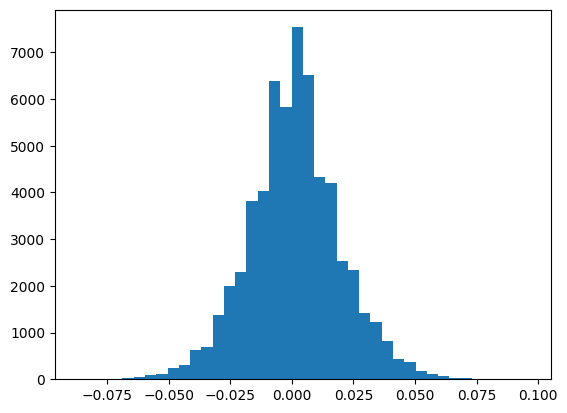

In [18]:
plt.hist(mem_est, bins=40)
plt.show()

In [19]:
np.max(mem_est)

np.float32(0.096000016)

In [2]:
with open('infl_mem.npz', 'rb') as f:
    feldman_dict = np.load('infl_mem.npz')

In [5]:
feldman_memorization = feldman_dict['memorization']

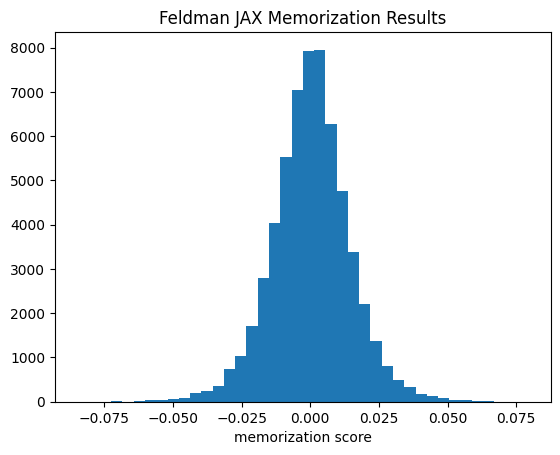

In [10]:
plt.hist(feldman_memorization, bins=40)
plt.title('Feldman JAX Memorization Results')
plt.xlabel('memorization score')
plt.show()

In [5]:
base_curv_scores = torch.load('./curv_scores/base.pt', weights_only=False)

(array([5.1568e+04, 5.9320e+03, 1.3170e+03, 4.9400e+02, 3.0400e+02,
        1.7700e+02, 1.0600e+02, 6.5000e+01, 2.8000e+01, 5.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([8.02781563e-10, 5.59370150e-04, 1.11873948e-03, 1.67810882e-03,
        2.23747804e-03, 2.79684737e-03, 3.35621671e-03, 3.91558651e-03,
        4.47495561e-03, 5.03432471e-03, 5.59369428e-03, 6.15306385e-03,
        6.71243295e-03, 7.27180205e-03, 7.83117209e-03, 8.39054119e-03,
        8.94991029e-03, 9.50927939e-03, 1.00686485e-02, 1.06280185e-02,
        1.11873876e-02, 1.17467567e-02, 1.23061268e-02, 1.28654959e-02,
        1.34248650e-02

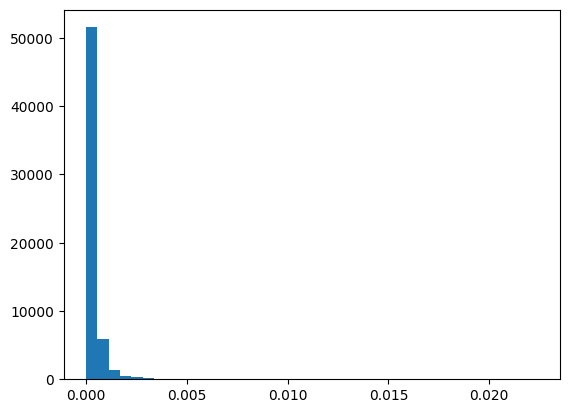

In [7]:
plt.hist(base_curv_scores, bins=40)